In [1]:
using CSV
using DataFrames
using JuMP
using HiGHS
using Plots 

In [2]:
# Read scenario data

df_wpp = CSV.read("./hourly_wpp_prod.csv", DataFrame, delim=",", header=true)
df_da = CSV.read("./da_prices_nov23.csv", DataFrame, delim=";", header=true)

g_w = convert(Vector{Float64}, df_wpp[:, "Tuulivoimatuotanto - tuntienergiatieto"]) # Hourly wind power production
g_w = reshape(g_w, (24, 15))
g_w = g_w./maximum(g_w) .* 9.6

λₜ = convert(Vector{Float64}, df_da[:, "Day-ahead Price (EUR/MWh)"])
λₜ = reshape(λₜ, (24, 15))

ψ_d = 0.7
ψ_u = 1.3

1.3

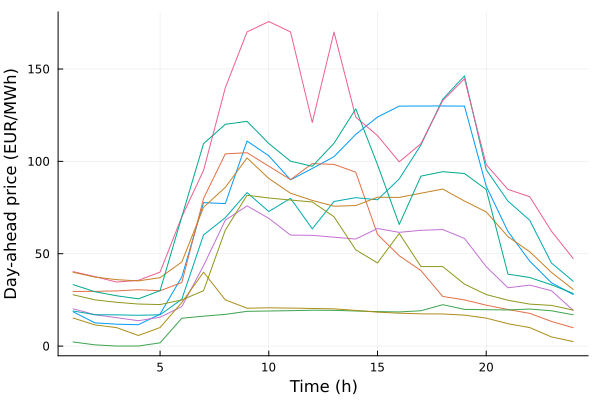

In [31]:
# Plot day-ahead prices

p = plot()
for i in range(1, 10)
    plot!([1:24], λₜ[:, i], legend=false, ylabel="Day-ahead price (EUR/MWh)", xlabel="Time (h)")
end
p
#savefig("prices.png")

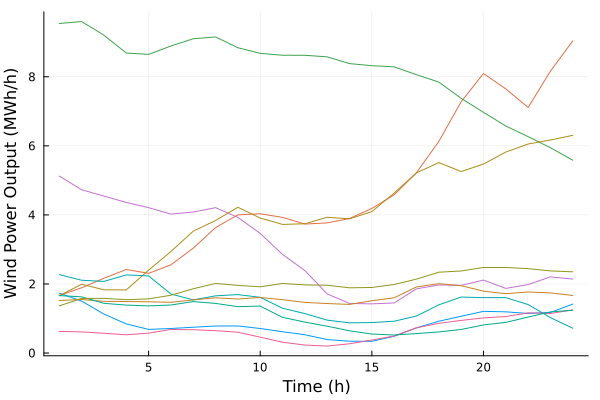

In [32]:
# Plot WPP output

p = plot()
for i in range(1, 10)
    plot!([1:24], g_w[:, i], legend=false, ylabel="Wind Power Output (MWh/h)", xlabel="Time (h)")
end
p
#savefig("WPP_output.png")

In [5]:
# Gather all data for the 2SSP model

J = 1 #CPP production blocks
P = 1:10 #DA price scenarios
T = 1:24 #Time periods
W = 1:10 #WPP output scenarios
ḡᶜ = 5.67 #CPP capacity
g_ᶜ = 2.5 #CPP minimum output
g_di = 1 #CPP initial down-time
g_dmin = 2 #CPP min down-time
g_ui = 0  #CPP initial up-time
g_umin = 2 #Cpp min up-time
ḡᵖ = 6 #PHSP pumping capacity
ḡᵗ = 8 #PHSP turbine capacity
k₀ = 100 #Fixed cost of the CPP
kⱼ = 20 #Marginal cost of jth production block in CPP
L_dmin = g_dmin-g_di #Number of time periods CPP has to be down at beginning
L_umin = 0 #Number of time periods CPP has to be up at beginning
rdᶜ = 3 #Ramp down limit
ruᶜ = 3 #Ramp up limit
stor_c = 40 #PHSP max capacity
SUC = 500 #CPP start-up cost
η = 0.75 #PHSP efficiency
πₚ = 1/15 #DA scenario probability
π_w = 1/15 #WPP output scenario probability

0.06666666666666667

In [6]:
# Implement the 2SSP model

m = Model(HiGHS.Optimizer)
#set_silent(m)

@variable(m, bm_u[t in T, w in W, p in P] >= 0) #Power sold in BM
@variable(m, bm_d[t in T, w in W, p in P] >= 0) #Power purchased in BM
@variable(m, Cᶜ[t in T, w in W, p in P] >= 0) #Total cost of CPP
@variable(m, gᶜ[t in T, w in W, p in P] >= 0) #CPP total output
@variable(m, gᵖ[t in T, w in W, p in P] >= 0) #PHSP pumping power
@variable(m, gᵗ[t in T, w in W, p in P] >= 0) #PHSP turbine power
@variable(m, G[t in T, p in P]) #Power sold or purchased in DA market
@variable(m, stor[t in T, w in W, p in P] >= 0) #Energy stored in PHSP
@variable(m, uᶜ[t in T, w in W, p in P], Bin) #Binary variable, 1 if CPP is producing power at time t, otherwise 0
@variable(m, vᶜ[t in T, w in W, p in P], Bin) #Binary variable, 1 if CPP is strated up at time t, otherwise 0

#Objective: Maximise expected profit
@objective(m, Max, sum(π_w*πₚ*
        (λₜ[t, p]*(G[t, p]+bm_d[t, w, p]*ψ_d-bm_u[t, w, p]*ψ_u)
            -Cᶜ[t, w, p]-SUC*vᶜ[t, w, p]) for t in T, w in W, p in P))

@constraint(m, [t in T[T.>1], w in W, p in P], uᶜ[t, w, p]-uᶜ[t-1, w, p] <= vᶜ[t, w, p]) #set appropriate value to v
@constraint(m, [t in T, w in W, p in P], Cᶜ[t, w, p] == k₀*uᶜ[t, w, p]+kⱼ*gᶜ[t, w, p]) #Define total cost of CPP
@constraint(m, [t in T, w in W, p in P], g_ᶜ*uᶜ[t, w, p] <= gᶜ[t, w, p]) #Lower limit for CPP output
@constraint(m, [t in T, w in W, p in P], ḡᶜ*uᶜ[t, w, p] >= gᶜ[t, w, p]) #Upper limit for CPP output
@constraint(m, [t in T[T.>1], w in W, p in P], -rdᶜ <= gᶜ[t, w, p]-gᶜ[t-1, w, p]) #Ramp limits for CPP outputs
@constraint(m, [t in T[T.>1], w in W, p in P], ruᶜ >= gᶜ[t, w, p]-gᶜ[t-1, w, p])

#Define up and down times for CPP
@constraint(m, [w in W, p in P], sum(uᶜ[t, w, p] for t in 1:L_dmin) == 0)
@constraint(m, [t in L_dmin+1:24-g_dmin+1, w in W, p in P], sum(1-uᶜ[tt, w, p] for tt in t:t+g_dmin-1) >= g_dmin*(uᶜ[t-1, w, p]-uᶜ[t, w, p]))
@constraint(m, [t in 24-g_dmin+2:24, w in W, p in P], sum(1-uᶜ[tt, w, p]-(uᶜ[t-1, w, p]-uᶜ[t, w, p]) for tt in t:24) >= 0)
@constraint(m, [w in W, p in P], sum(1-uᶜ[t, w, p] for t in 1:L_umin) == 0)
@constraint(m, [t in L_umin+1:24-g_umin+1, w in W, p in P], sum(uᶜ[tt, w, p] for tt in t:t+g_dmin-1) >= g_umin*vᶜ[t, w, p])
@constraint(m, [t in 24-g_umin+2:24, w in W, p in P], sum(uᶜ[tt, w, p]-vᶜ[t, w, p] for tt in t:24) >= 0)

@constraint(m, [t in T, w in W, p in P], gᵗ[t, w, p] <= ḡᵗ) #Upper limit for turbine output
@constraint(m, [t in T, w in W, p in P], gᵖ[t, w, p] <= ḡᵖ) #Upper limit for pumping power
@constraint(m, [w in W, p in P], stor[1, w, p] == gᵖ[1, w, p]-gᵗ[1, w, p]) #Update storage values
@constraint(m, [t in T[T.>1], w in W, p in P], stor[t, w, p] == stor[t-1, w, p]+gᵖ[t, w, p]-gᵗ[t, w, p])
@constraint(m, [t in T, w in W, p in P], stor[t, w, p] <= stor_c) #Upper limit for storage capacity
@constraint(m, [t in T, w in W, p in P], g_w[t, w]+gᶜ[t, w, p]+gᵗ[t, w, p]+bm_u[t, w, p] 
    == G[t, p] + gᵖ[t, w, p]/η + bm_d[t, w, p]) #Produced and purchased energy equals consumed and sold energy
@constraint(m, [t in T, p in P, pp in  P], (G[t, p]-G[t, pp])*(λₜ[t, p]-λₜ[t, pp]) >= 0) #Make bids non-decreasing


optimize!(m);

Running HiGHS 1.4.0 [date: 1970-01-01, git hash: bcf6c0b22]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
22660 rows, 19140 cols, 65920 nonzeros
16980 rows, 16740 cols, 81360 nonzeros
16980 rows, 16740 cols, 81360 nonzeros

Solving MIP model with:
   16980 rows
   16740 cols (4500 binary, 0 integer, 0 implied int., 12240 continuous)
   81360 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   inf             -inf                 inf        0      0      0         0     0.2s
 R       0       0         0   0.00%   3561.852943     3442.755616        3.46%        0      0      0     10639     1.1s
 C       0       0         0   0.00%   3536.449038     3513.640867        0.65%     8200    522      0     12518     2.4s
         0 

In [7]:
# Gather optimal values

obj = objective_value(m)
bid = convert(Matrix{Float64}, value.(G))
phsp = convert(Array{Float64}, value.(stor))
cpp = convert(Array{Float64}, value.(gᶜ))
cost = convert(Array{Float64}, value.(Cᶜ))
start = convert(Array{Float64}, value.(vᶜ))
bmu = convert(Array{Float64}, value.(bm_u))
bmd = convert(Array{Float64}, value.(bm_d))
expected_profit = sum(πₚ*π_w*(λₜ[:, p].*(bid[:, p]+bmd[:, w, p]*ψ_d-bmu[:, w, p]*ψ_u)-cost[:, w, p]-SUC*start[:, w, p]) for w in W, p in P)
print(obj)

3529.2706281458627

In [29]:
# Plot expected profits

plot(T, cumsum(expected_profit), label="Expected cumulative profit", ylabel="Profit (EUR)", xlabel="Time (h)")
plot!(T, expected_profit, label="Hourly expected profit")
#savefig("expected_profit.png")

"/notebooks/SPaRO/project/expected_profit.png"

In [37]:
# Plot the day-ahead bid and behaviour of VPP in scenario (w, p)

w = 3
p = 1

plot(T, bid[:, p], label="Day-ahead bid", xlabel="Time (h)", ylabel="Power (MW)")
plot!(T[2:end], -phsp[2:end, w, p]+phsp[1:end-1, w, p], label="PHSP output")
plot!(T, cpp[:, w, p], label="CPP output")
plot!(T, g_w[:, w], label="WPP output")
plot!(T, bmd[:, w, p]-bmu[:, w, p], label="Balancing market")
#savefig("high_w_high_p.png")

"/notebooks/SPaRO/project/high_w_high_p.png"

In [30]:
# Plot offering curves for certain hours

hours = [2, 8, 12, 19, 24]
p = plot()
for i in hours
    plot!(sort(λₜ[i, 1:10]), sort(bid[i, 1:10]), label=string("Hour ", i), xlabel="Electricity price (EUR/MWh)", ylabel="Offered electricity (MWh)")
end
p
#savefig("offering_curves.png")

"/notebooks/SPaRO/project/offering_curves.png"

In [23]:
# Model without CPP
m2 = Model(HiGHS.Optimizer)
#set_silent(m)

@variable(m2, bm_u[t in T, w in W, p in P] >= 0) #Power sold in BM
@variable(m2, bm_d[t in T, w in W, p in P] >= 0) #Power purchased in BM
@variable(m2, gᵖ[t in T, w in W, p in P] >= 0) #PHSP pumping power
@variable(m2, gᵗ[t in T, w in W, p in P] >= 0) #PHSP turbine power
@variable(m2, G[t in T, p in P] >= 0) #Power sold of purchased in DA market
@variable(m2, stor[t in T, w in W, p in P] >= 0) #Energy stored in PHSP

#Objective: Maximise expected profit
@objective(m2, Max, sum(π_w*πₚ*
        (λₜ[t, p]*(G[t, p]+bm_d[t, w, p]*ψ_d-bm_u[t, w, p]*ψ_u))
        for t in T, w in W, p in P))

@constraint(m2, [t in T, w in W, p in P], gᵗ[t, w, p] <= ḡᵗ)
@constraint(m2, [t in T, w in W, p in P], gᵖ[t, w, p] <= ḡᵖ)
@constraint(m2, [w in W, p in P], stor[1, w, p] == gᵖ[1, w, p]-gᵗ[1, w, p])
@constraint(m2, [t in T[T.>1], w in W, p in P], stor[t, w, p] == stor[t-1, w, p]+gᵖ[t, w, p]-gᵗ[t, w, p])
@constraint(m2, [t in T, w in W, p in P], stor[t, w, p] >= 0)
@constraint(m2, [t in T, w in W, p in P], stor[t, w, p] <= stor_c)
@constraint(m2, [t in T, w in W, p in P], g_w[t, w]+gᵗ[t, w, p] + bm_u[t, w, p] == G[t, p] + gᵖ[t, w, p]/η + bm_d[t, w, p])
@constraint(m2, [t in T, p in P, pp in  P], (G[t, p]-G[t, pp])*(λₜ[t, p]-λₜ[t, pp]) >= 0)


optimize!(m2);

Running HiGHS 1.4.0 [date: 1970-01-01, git hash: bcf6c0b22]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
6960 rows, 12240 cols, 25820 nonzeros
5880 rows, 12240 cols, 23660 nonzeros
Presolve : Reductions: rows 5880(-10920); columns 12240(-0); elements 23660(-11760)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -1.5804370270e+03 Ph1: 3072(7307.59); Du: 2640(1580.44) 0s
       8641    -2.1441822507e+03 Pr: 0(0); Du: 0(4.94049e-15) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 8641
Objective value     :  2.1441822507e+03
HiGHS run time      :          0.22
